In [2]:
import numpy as np
import os
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
from astropy.io import ascii
from astropy.coordinates import SkyCoord 
import healpy
import astropy.units as u
import pandas as pd
import matplotlib
from magnification_library import *
import pyccl
from scipy import stats

os.environ['CLMM_MODELING_BACKEND'] = 'ccl' # here you may choose ccl, nc (NumCosmo) or ct (cluster_toolkit)

import clmm
from clmm.support.sampler import fitters

from importlib import reload  

In [3]:
clmm.__version__

'0.9.4'

In [4]:
matplotlib.rcParams.update({'font.size': 14})

In [5]:
#define cosmology

#astropy object
cosmo = FlatLambdaCDM(H0=71, Om0=0.265, Tcmb0=0 , Neff=3.04, m_nu=None, Ob0=0.0448)

#ccl object
cosmo_ccl = pyccl.Cosmology(Omega_c=cosmo.Om0-cosmo.Ob0, Omega_b=cosmo.Ob0,
                      h=cosmo.h, sigma8= 0.80, n_s=0.963)
#clmm object
cosmo_clmm = clmm.Cosmology(be_cosmo=cosmo_ccl)

## Open data

In [6]:
path_file = '../'

In [7]:
key = 'LBGp'

gal_cat_raw =  pd.read_hdf(path_file+'input_data/cat_'+key+'.h5', key=key)
dat = np.load(path_file+"input_data/source_sample_properties.npy", allow_pickle=True)
mag_cut, alpha_cut, mag_null, gal_dens = dat[np.where(dat[:,0]==key)][0][1:]

print (alpha_cut)
mag_cut

3.320964657712193


25.495

In [8]:
selection_source = (gal_cat_raw['ra']>50) & (gal_cat_raw['ra']<73.1) & (gal_cat_raw['dec']<-27.) & (gal_cat_raw['dec']>-45.)
selection = selection_source & (gal_cat_raw['mag_i_lsst']<mag_cut) & (gal_cat_raw['redshift']>1.5)

gal_cat = gal_cat_raw[selection]

In [9]:
quant = np.load(path_file + "output_data/binned_correleation_fct_"+key+".npy", allow_pickle=True)
quant_NK = np.load(path_file + "output_data/binned_correleation_fct_NK_"+key+".npy", allow_pickle=True)

In [10]:
[z_cl, mass_cl, n_halo] = np.load(path_file + "output_data/halo_bin_properties.npy", allow_pickle=True)

In [11]:
np.sum(n_halo)

21982.0

## Open halo catalog and define binning

In [18]:
halo_cat =  pd.read_hdf(path_file + 'input_data/cat_halos.h5')

selection_halo = ( halo_cat['ra']>50) & ( halo_cat['ra']<73.1) & ( halo_cat['dec']<-27.) & ( halo_cat['dec']>-45.)

In [19]:
zbins = np.array(([0.2,0.4],[0.4,0.6],[0.6,0.8],[0.8,1.0], [1.0, 1.2]))

In [20]:
mbins = np.array(([20,30],[30,45],[45,70],[70,120],[120,220]))*(1e14/45)

In [21]:
bin_sel = np.zeros((zbins.shape[0], mbins.shape[0]), dtype=object)
for i in np.arange(zbins.shape[0]):
    for j in np.arange(mbins.shape[0]):
        bin_sel[i,j] = selection_halo & (halo_cat['redshift']> zbins[i][0]) & (halo_cat['redshift']< zbins[i][1]) & (halo_cat['halo_mass']> mbins[j][0]) & (halo_cat['halo_mass']< mbins[j][1])

In [22]:
wide_selection = selection_halo *  (halo_cat['redshift']> zbins.min()) & (halo_cat['redshift']< zbins.max()) & (halo_cat['halo_mass']> mbins.min()) & (halo_cat['halo_mass']< mbins.max())

/pbs/throng/lsst/software/desc/common/miniconda/py38_4.9.2/envs/desc/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


In [23]:
np.sum(wide_selection)

21982

## Select galaxies around clusters

In [24]:
source = SkyCoord(gal_cat.ra.values*u.deg, gal_cat.dec.values*u.deg)

In [25]:
match = np.zeros(z_cl.shape, dtype=object)

In [26]:
#rmin_Mpc, rmax_Mpc = 0.1*u.Mpc, 7*u.Mpc
rmin_Mpc, rmax_Mpc = 0.1*u.Mpc, 3.5*u.Mpc

bin_dict={'min_sep':0.1, 'max_sep':20, 'sep_units':'arcmin','bin_type':'Log','nbins':10, 'var_method':'shot'}



for i in np.arange(zbins.shape[0]):
    for j in np.arange(mbins.shape[0]):
        #conv = cosmo.arcsec_per_kpc_proper(z_cl[i,j]).to(u.arcmin/u.Mpc)
        #sep_max = conv * rmax_Mpc
        lens = SkyCoord(halo_cat[bin_sel[i,j]].ra.values*u.deg, halo_cat[bin_sel[i,j]].dec.values*u.deg)
        match[i,j] = source.search_around_sky(lens, bin_dict['max_sep']*u.arcmin)


# Magnification stacked profiles

In [27]:
bins = clmm.make_bins(bin_dict['min_sep'], bin_dict['max_sep'], nbins=bin_dict['nbins'], method='evenlog10width')

mu_profiles = np.zeros(z_cl.shape, dtype=object)

for i in np.arange(zbins.shape[0]):
    for j in np.arange(mbins.shape[0]):
        #conv = cosmo.arcsec_per_kpc_proper(z_cl[i,j]).to(u.arcmin/u.Mpc)
        #bins = clmm.make_bins((conv * rmin_Mpc).value, (conv * rmax_Mpc).value, nbins=nbins, method='evenlog10width')
        mu_profiles[i,j] = clmm.compute_radial_averages(match[i,j][2].to(u.arcmin).value, gal_cat['magnification'].iloc[match[i,j][1]], bins, error_model='std/sqrt_n')

/pbs/throng/lsst/software/desc/common/miniconda/py38_4.9.2/envs/desc/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


In [28]:
corr_mean= gal_cat['magnification'].mean()

corr_1 = np.zeros(z_cl.shape)
corr_2 = np.zeros(z_cl.shape)

for i in range(len(z_cl)):
    for j in range(len(z_cl)):
        corr_1[i,j] = mu_profiles[i,j][1][-1]
        corr_2[i,j] = gal_cat['magnification'].iloc[match[i,j][1]].mean()

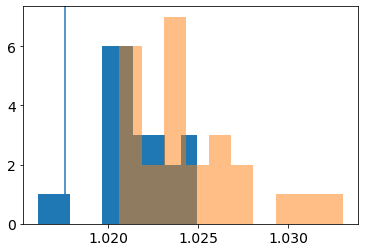

In [29]:
plt.hist(corr_1.flatten())
plt.hist(corr_2.flatten(),alpha=0.5)
plt.axvline(corr_mean)

In [30]:
def Mpc_to_arcmin(x_Mpc, z, cosmo=cosmo):
    return x_Mpc * cosmo.arcsec_per_kpc_proper(z).to(u.arcmin/u.Mpc).value

def arcmin_to_Mpc(x_arc, z, cosmo=cosmo):
    return x_arc * cosmo.kpc_proper_per_arcmin(z).to(u.Mpc/u.arcmin).value 

In [31]:
def magnification_biais_model(rproj, mass_lens, z_lens, alpha, z_source, cosmo_clmm, delta_so='200', massdef='mean', Mc_relation ='Diemer15'):
    
    conc = get_halo_concentration(mass_lens, z_lens, cosmo_clmm.be_cosmo, Mc_relation, mdef[0], delta_so )
    magnification = np.zeros(len(rproj))
    for k in range(len(rproj)):

        magnification[k] = np.mean(clmm.theory.compute_magnification(rproj[k], mdelta=mass_lens, cdelta=conc, 
                                        z_cluster=z_lens, z_source=z_source, cosmo=cosmo_clmm, 
                                        delta_mdef=delta_so, 
                                        massdef = massdef,
                                        halo_profile_model='einasto', 
                                        z_src_model='single_plane'))

        
    model = mu_bias(magnification, alpha) - 1. 
    
    return model, magnification
    

In [32]:
def get_halo_concentration(mass_lens, z_lens, cosmo_ccl, relation="Diemer15", mdef="matter", delta_so=200):
    mdef = pyccl.halos.massdef.MassDef(delta_so, mdef, c_m_relation=relation)
    concdef = pyccl.halos.concentration.concentration_from_name(relation)()
    conc = concdef.get_concentration(cosmo=cosmo_clmm.be_cosmo, M=mass_lens, a=cosmo_clmm._get_a_from_z(z=z_lens), mdef_other=mdef)
    return conc 

In [ ]:
hist = plt.hist(gal_cat['redshift'][selection], bins=100, range=[1.8,3.1], density=True, stacked=True);
pdf_zsource = zpdf_from_hist(hist, zmin=0, zmax=10)
plt.plot(pdf_zsource.x, pdf_zsource.y, 'r')
plt.xlim(1,3.4)

plt.xlabel('z source')
plt.ylabel('pdf')

In [34]:
zint = np.linspace(0, 3.5, 1000)
zrand = np.random.choice(zint, 1000, p=pdf_zsource(zint)/np.sum(pdf_zsource(zint)))

In [35]:
Mc_relation = "Diemer15"
mdef = ["matter", "mean"] #differet terminology for ccl and clmm
delta_so=200


#model with the full redshift distribution
rp = np.logspace(-2, 2, 100)

model_mbias = np.zeros((rp.size, len(z_cl), len(mass_cl)))
model_magnification = np.zeros((rp.size, len(z_cl), len(mass_cl)))

for i in np.arange(z_cl.shape[0]):
    for j in np.arange(mass_cl.shape[1]):
        rp_Mpc = arcmin_to_Mpc(rp, z_cl[i,j], cosmo)
        models = magnification_biais_model(rp_Mpc, mass_cl[i,j], z_cl[i,j], alpha_cut, zrand, cosmo_clmm, delta_so, massdef=mdef[1], Mc_relation=Mc_relation)
        model_mbias[:,i,j] = models[0]
        model_magnification[:,i,j] = models[1]

/pbs/throng/lsst/users/mricci/desc/CLMM/clmm/theory/ccl.py:96: RuntimeWarning: invalid value encountered in log
  ptf = interp1d(np.log(rtmp), np.log(tmp), bounds_error=False, fill_value=-100)
/pbs/throng/lsst/users/mricci/desc/CLMM/clmm/theory/ccl.py:107: RuntimeWarning: invalid value encountered in log
  ptf = interp1d(np.log(rtmp), np.log(tmp), bounds_error=False, fill_value=-100)


(0.9, 1.2)

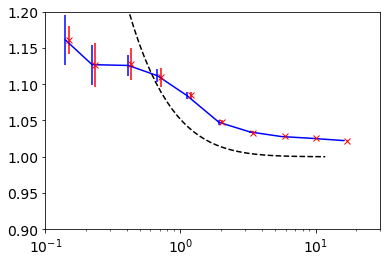

In [50]:
i,j = 4,2

plt.errorbar(quant_NK[i,j][0], quant_NK[i,j][1], yerr = np.sqrt(np.diag(quant_NK[i,j][2])),fmt='b-')#+  corr[i,j],yerr=np.sqrt(np.diag(quant_NK[i,j][2])),fmt='.-')
plt.errorbar(mu_profiles[i,j][0]*1.05, mu_profiles[i,j][1], yerr= mu_profiles[i,j][2], fmt='rx')

plt.plot(rp, model_magnification[:,i,j],'k--')

plt.xscale('log')
plt.xlim(0.1,30)
plt.ylim(0.9,1.2)



### error measurements for TreeCorr => Var(rbin) = Var(all galaxies)/n_gal_rbin
### error measurements for TreeCorr => Var(rbin) = Var(gal rbin)/n_gal_rbin

In [ ]:
fig, axes = plt.subplots(5,5, figsize=[20,15], sharex=True)

corr = np.ones(z_cl.shape) * corr_mean


for i,h in zip([0,1,2,3,4],range(5)):
    for j,k in zip([0,1,2,3,4],range(5)):
        
        def func_Mpc_to_arcmin(x_Mpc):
            return Mpc_to_arcmin(x_Mpc, z=z_cl[i,j], cosmo=cosmo)
        
        def func_arcmin_to_Mpc(x_arc):
            return arcmin_to_Mpc(x_arc, z=z_cl[i,j], cosmo=cosmo)
        
        ax = axes[5-1-k,h]
        
        ax.errorbar(quant_NK[i,j][0],quant_NK[i,j][1] ,yerr=np.sqrt(np.diag(quant_NK[i,j][2])),fmt='.-')
        ax.errorbar(mu_profiles[i,j][0], mu_profiles[i,j][1] - corr[i,j] + 1, yerr=mu_profiles[i,j][2], fmt='')

        ax.axvline(1*healpy.nside2resol(4096, arcmin = True), linestyle="dashed")
    
        secax = ax.secondary_xaxis('top', functions=(func_arcmin_to_Mpc, func_Mpc_to_arcmin))
        secax.set_xlabel('$\\theta$ [Mpc]')

        r200 = scaled_radius(200, mass_cl[i,j], z_cl[i,j], cosmo)
        ax.axvline(func_Mpc_to_arcmin(r200))
        ax.axvline(func_Mpc_to_arcmin(0.25*r200))

        ax.text(0.55, 0.80, "<z>="+str(round(z_cl[i,j],2)), transform=ax.transAxes, fontsize='x-small')
        ax.text(0.55, 0.90, "<M/1e14>="+str(round(mass_cl[i,j]/1e14,2)), transform=ax.transAxes, fontsize='x-small');
        
        ax.axvspan(func_Mpc_to_arcmin(rmin_Mpc.value - 0.05), func_Mpc_to_arcmin(rmax_Mpc.value + 0.05), color='green', alpha=0.1, lw=0)
        
        ax.set_xlabel('$\\theta$ [arcmin]')
        ax.set_ylabel('$\mu$')
        #ax.axhline(1)
        
        #ax.plot(mu_profiles[i,2][0], fmodel_guess[i, int(ind[i,j,k])](mu_profiles[i,2][0]),'r')
        ax.plot(rp, model_magnification[:,i,j],'k--')
        
plt.tight_layout()

plt.xlabel('$\\theta$ [arcmin]')
plt.ylabel('$\mu$')

axes[0,0].set_xscale('log')
axes[0,0].set_xlim(0.1,30)

for i in range(axes.shape[0]):
    axes[4,i].set_ylim(0.99,1.15)
    axes[3,i].set_ylim(0.99,1.15)
    axes[2,i].set_ylim(0.99,1.2)
    axes[1,i].set_ylim(0.99,1.3)
    axes[0,i].set_ylim(0.99,1.5)

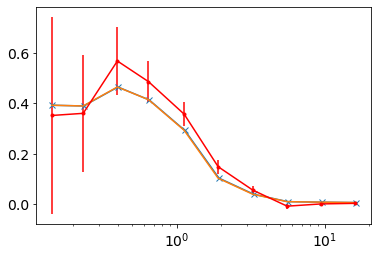

In [58]:
i,j = 1,2

plt.errorbar(mu_profiles[i,j][0],  mu_bias(mu_profiles[i,j][1] - corr_mean + 1, alpha_cut) - 1 , fmt='x-', ecolor='black')
plt.errorbar(quant_NK[i,j][0], mu_bias(quant_NK[i,j][1] -corr_mean + 1, alpha_cut) -1 ) #, yerr=mu_profiles[i,j][2], fmt='x-', ecolor='black')
plt.errorbar(quant[i,j][0], quant[i,j][1],yerr=np.sqrt(np.diag(quant[i,j][2])),fmt='.-', ecolor='red',color='red')

plt.xscale('log')


In [ ]:
mean_corr = corr_mean - 1
#mean_corr = 1

fig, axes = plt.subplots(5,5, figsize=[20,15], sharex=True)
for i,h in zip([0,1,2,3,4],range(5)):
    for j,k in zip([0,1,2,3,4],range(5)):
        
        def func_Mpc_to_arcmin(x_Mpc):
            return Mpc_to_arcmin(x_Mpc, z=z_cl[i,j], cosmo=cosmo)
        
        def func_arcmin_to_Mpc(x_arc):
            return arcmin_to_Mpc(x_arc, z=z_cl[i,j], cosmo=cosmo)
        
        ax = axes[5-1-k,h]
        
        ax.errorbar(mu_profiles[i,j][0],  mu_bias(mu_profiles[i,j][1]-mean_corr,alpha_cut) -1) #, yerr=mu_profiles[i,j][2], fmt='x-', ecolor='black')
        ax.errorbar(quant_NK[i,j][0], mu_bias(quant_NK[i,j][1] -mean_corr , alpha_cut)-1 )
        ax.errorbar(quant[i,j][0],quant[i,j][1],yerr=np.sqrt(np.diag(quant[i,j][2])),fmt='o', ecolor='red')
        
        ax.loglog(rp, model_mbias[:,i,j],'k--')
        #ax.axvline(1*healpy.nside2resol(4096, arcmin = True), linestyle="dashed")
    
        ##secax = ax.secondary_xaxis('top', functions=(func_arcmin_to_Mpc, func_Mpc_to_arcmin))
        ##secax.set_xlabel('$\\theta$ [Mpc]')

        #r200 = scaled_radius(200, mass_cl[i,j], z_cl[i,j], cosmo)
        #ax.axvline(func_Mpc_to_arcmin(r200))
        #ax.axvline(func_Mpc_to_arcmin(0.25*r200))

        ax.text(0.55, 0.80, "<z>="+str(round(z_cl[i,j],2)), transform=ax.transAxes, fontsize='x-small')
        ax.text(0.55, 0.90, "<M/1e14>="+str(round(mass_cl[i,j]/1e14,2)), transform=ax.transAxes, fontsize='x-small');
        
        #ax.axvspan(func_Mpc_to_arcmin(0.2), func_Mpc_to_arcmin(3.5), color='green', alpha=0.1, lw=0)
        
        ax.set_xlabel('$\\theta$ [arcmin]')
        ax.set_ylabel('$\mu$')
        ax.axhline(0)
        
        
plt.tight_layout()

plt.xlabel('$\\theta$ [arcmin]')
plt.ylabel('$\mu$')

axes[0,0].set_xscale('log')
axes[0,0].set_xlim(0.1,30)

for i in range(axes.shape[0]):
    axes[4,i].set_ylim(-0.4,0.8)
    axes[3,i].set_ylim(-0.1,1.5)
    axes[2,i].set_ylim(-0.3,1.5)
    axes[1,i].set_ylim(-0.5,3.0)
    axes[0,i].set_ylim(-1.0,4.0)

In [61]:
from scipy.ndimage import gaussian_filter1d

In [62]:
def gaussian_filter1d(x0 ,sigma, rp, model):
    gaussian = 1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-(rp - x0)**2/(2*sigma**2)) 
    return model - gaussian

In [63]:

def gaussian(rp, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    x = np.log(rp)
    return (amp / (rp * np.sqrt(2*np.pi) * wid)) * np.exp(-(x-cen)**2 / (2*wid**2)) + 1

In [64]:
from scipy.optimize import curve_fit

In [65]:
def beta_model(rp, n0):
    """Beta model"""
    nc=1.
    alpha=0
    beta = 0.5
    rc = nc * healpy.nside2resol(4096, arcmin = True)
    return n0 * (rp/rc)**alpha * (1 +(rp/rc)**2)**(-3*beta/2 + alpha/2) + 1

In [66]:
nparam = 1
popt = np.zeros((nparam,5,5))
pcov = np.zeros((nparam,nparam,5,5))

for i in np.arange(z_cl.shape[0]):
    for j in np.arange(mass_cl.shape[1]):
        ind = mu_profiles[i,j][2]>0
        popt[:,i,j], pcov[:,:,i,j] = curve_fit(beta_model, mu_profiles[i,j][0][ind], mu_profiles[i,j][1][ind]-corr[i,j] + 1, sigma = mu_profiles[i,j][2][ind], absolute_sigma=True, p0=(0.2), maxfev=2000)

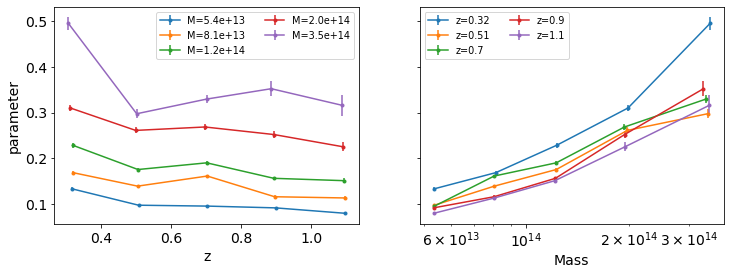

In [67]:
par = 0

fig, (ax1,ax2) = plt.subplots(1,2, figsize=[12,4], sharey=True)

#[plt.plot(z_cl[:,i],popt[par,:,i],'o-') for i in range(5)];
[ax1.errorbar(z_cl[:,i], popt[par,:,i], yerr = np.sqrt(pcov[par,par,:,i]), fmt='.-', label=f'M={mass_cl[0,i]:.1e}') for i in range(5)];
ax1.set_xlabel('z')
ax1.set_ylabel('parameter')
ax1.legend(ncol=2, fontsize='x-small')

[ax2.errorbar(mass_cl[i,:], popt[par,i,:], yerr = np.sqrt(pcov[par,par,i,:]), fmt='.-',label=f'z={z_cl[i,0]:.2}') for i in range(5)];
ax2.set_xscale('log')
ax2.set_xlabel('Mass')
ax2.legend(ncol=2, fontsize='x-small')

<ErrorbarContainer object of 3 artists>

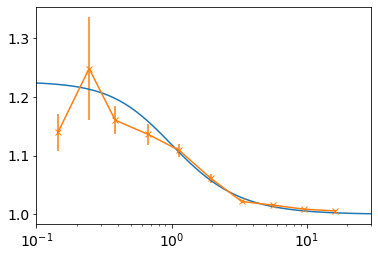

In [68]:
i,j=4,3
plt.plot(rp,beta_model(rp,*popt[:,i,j]))
plt.xscale('log')
#plt.yscale('log')
plt.xlim(0.1,30)
ind = mu_profiles[i,j][2]>0
plt.errorbar(mu_profiles[i,j][0][ind], mu_profiles[i,j][1][ind]-corr[i,j]+1 , yerr=mu_profiles[i,j][2][ind], fmt='x-')
#plt.ylim(0.99,1.2)

<ipython-input-70-3414ac470aa1>:13: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(-2,2)


(0.001, 1.2)

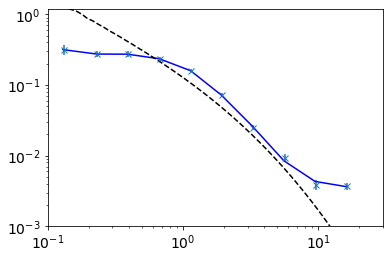

In [70]:
i,j = 1,3

plt.plot(quant_NK[i,j][0], quant_NK[i,j][1]-corr[i,j],'b')#+  corr[i,j],yerr=np.sqrt(np.diag(quant_NK[i,j][2])),fmt='.-')
plt.errorbar(mu_profiles[i,j][0], mu_profiles[i,j][1]-corr[i,j], yerr=mu_profiles[i,j][2], fmt='x')

plt.plot(rp, model_magnification[:,i,j]-1,'k--')

#plt.plot(rp, test,'r',lw=2)

plt.xscale('log')
plt.yscale('log')
plt.xlim(0.1,30)
plt.ylim(-2,2)
plt.ylim(1e-3,1.2)

# Magnification stacked profiles

In [57]:
gal_cat['magnification'].mean()

1.0175687388031425

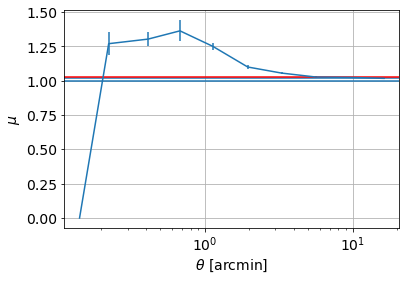

In [58]:
i,j = 4,4
#corr = gal_cat['magnification'][match[i,j][1]].mean()
corr=0

plt.errorbar(mu_profiles[i,2][0], mu_profiles[i,j][1] - corr,yerr=mu_profiles[i,j][2], fmt='')
plt.xscale('log')

plt.xlabel('$\\theta$ [arcmin]')
plt.ylabel('$\mu$')
plt.grid()
plt.axhline(1)
plt.axhline(gal_cat['magnification'].mean())
plt.axhline(gal_cat['magnification'].iloc[match[i,2][1]].mean(),color='red')

In [93]:
def Mpc_to_arcmin(x_Mpc, z, cosmo=cosmo):
    return x_Mpc * cosmo.arcsec_per_kpc_proper(z).to(u.arcmin/u.Mpc).value

def arcmin_to_Mpc(x_arc, z, cosmo=cosmo):
    return x_arc * cosmo.kpc_proper_per_arcmin(z).to(u.Mpc/u.arcmin).value 

## Fit masses

In [94]:
def get_halo_concentration(mass_lens, z_lens, cosmo, cosmo_ccl, relation="Diemer15", mdef="matter", delta_so=200):
    mdef = pyccl.halos.massdef.MassDef(delta_so, mdef, c_m_relation=relation)
    concdef = pyccl.halos.concentration.concentration_from_name(relation)()
    conc = concdef.get_concentration(cosmo=cosmo_ccl, M=mass_lens, a=cosmo.scale_factor(z_lens), mdef_other=mdef)
    return conc 

In [95]:
def magnification_model(rproj, mass_lens, z_lens, z_source, cosmo, cosmo_ccl):
    
    conc = get_halo_concentration(mass_lens, z_lens, cosmo, cosmo_ccl)
    magnification = np.zeros(len(rproj))
    for k in range(len(rproj)):

        magnification[k] = np.mean(mod.predict_magnification(rproj[k]*cosmo.h, mdelta=mass_lens*cosmo.h, cdelta=conc, 
                                        z_cluster=z_lens, z_source=z_source, cosmo=cosmo, 
                                        delta_mdef=200, 
                                        halo_profile_model='NFW', 
                                        z_src_model='single_plane'))

        
    model = magnification
    
    return model
    

In [96]:
Mc_relation = "Diemer15"
mdef = "matter"
delta_so=200

print("Model parameters : mass_concentration relation =", Mc_relation,\
      "; mass definition = SO mass within radius such that the density is ",delta_so, "times that of the ", mdef, "density of Universe at that redshift")

conc = np.zeros((5,5))
for i in np.arange(z_cl.shape[0]):
    for j in np.arange(mass_cl.shape[1]):
        conc[i,j] = get_halo_concentration(mass_cl[i,j], z_cl[i,j], cosmo, cosmo_ccl, Mc_relation, mdef=mdef, delta_so=delta_so)

Model parameters : mass_concentration relation = Diemer15 ; mass definition = SO mass within radius such that the density is  200 times that of the  matter density of Universe at that redshift


In [97]:
mass_guess = np.logspace(12,16,500, base=10)

In [98]:
rp = np.logspace(-2, 1, 100)

Text(0, 0.5, 'pdf')

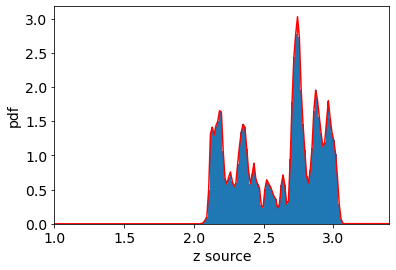

In [99]:
hist = plt.hist(gal_cat['redshift'][selection], bins=100, range=[1.8,3.1], density=True, stacked=True);
pdf_zsource = zpdf_from_hist(hist, zmin=0, zmax=10)
plt.plot(pdf_zsource.x, pdf_zsource.y, 'r')
plt.xlim(1,3.4)

plt.xlabel('z source')
plt.ylabel('pdf')

In [100]:
zint = np.linspace(0, 3.5, 1000)

In [101]:
zrand = np.random.choice(zint, 1000, p=pdf_zsource(zint)/np.sum(pdf_zsource(zint)))

In [102]:
#model with the full redshift distribution


rbins = clmm.polaraveraging.make_bins((rmin_Mpc).value, (rmax_Mpc).value, nbins=nbins, method='evenlog10width')
rsep = rbins[:-1] + 0.5*(rbins[1:]-rbins[:-1])

model = np.zeros((rbins.size-1, len(z_cl), len(mass_cl)))
for i in np.arange(z_cl.shape[0]):
    for j in np.arange(mass_cl.shape[1]):
        model[:,i,j] = magnification_model(rsep, mass_cl[i,j], z_cl[i,j],  zrand, cosmo, cosmo_ccl)

In [103]:
if path.isfile("output_data/evaluated_model_magnification_"+key+"_"+mdef+str(delta_so)+"_cM_"+Mc_relation+".npy"):
    fmodel_guess =  np.load("output_data/evaluated_model_magnification_"+key+"_"+mdef+str(delta_so)+"_cM_"+Mc_relation+".npy", allow_pickle=True)
else :
    print("Model computation, take a few minutes")
    fmodel_guess = np.zeros((len(z_cl), len(mass_guess)), dtype=object)
    model_guess = np.zeros((rp.size, len(mass_guess), len(z_cl)))

    for i in range(len(z_cl)):
        print(i)
        for l in range(len(mass_guess)):
            model_guess[:, l, i] = magnification_model(rp, mass_guess[l], z_cl[i,0], zrand, cosmo, cosmo_ccl)
            x = Mpc_to_arcmin(rp, z=z_cl[i,0], cosmo=cosmo)
            fmodel_guess[i, l] = itp.interp1d(x, model_guess[:, l, i])
            
    np.save("output_data/evaluated_model_magnification_"+key+"_"+mdef+str(delta_so)+"_cM_"+Mc_relation,fmodel_guess)

In [104]:
corr_mean= gal_cat['magnification'].mean()

corr = np.zeros(z_cl.shape)

for i in range(len(z_cl)):
    for j in range(len(z_cl)):
        corr[i,j] = gal_cat['magnification'].iloc[match[i,j][1]].mean()

In [105]:
corr, corr_mean

(array([[1.02559819, 1.02631739, 1.02773319, 1.03369601, 1.04759119],
        [1.023995  , 1.02706657, 1.0294996 , 1.03545895, 1.03757485],
        [1.02729483, 1.03266272, 1.03584843, 1.0409798 , 1.05396652],
        [1.02772509, 1.02998121, 1.03526606, 1.0436104 , 1.05250731],
        [1.02594579, 1.03136626, 1.03375687, 1.04322667, 1.05364261]]),
 1.0175687388031425)

In [106]:
#step_low = 0 + np.array([0,1,2,3,4,5,6])
#step_high = rsep.size - np.array([0,1,2,3])

#rbounds = np.zeros((2,step_high.size*step_low.size),dtype=int)

#rbounds[0,:]  = step_low.repeat(step_high.size)
#rbounds[1,:] = np.tile(step_high,step_low.size)

step_low = 0
step_high= 7

In [107]:
#chi2_val = np.zeros((z_cl.shape[0], z_cl.shape[1], step_low.size*step_high.size, len(mass_guess)))
chi2_val = np.zeros((z_cl.shape[0], z_cl.shape[1], len(mass_guess)))

for i in range(len(z_cl)):
    for j in range(len(z_cl)):
        #for k in range(step_low.size*step_high.size):
        for l in range(len(mass_guess)):
            chi2_val[i,j,l] = sum_chi2(mu_profiles[i,j][1]-corr_mean, mu_profiles[i,j][2]+1e-4, fmodel_guess[i,l](mu_profiles[i,j][0])-1 , step_low=step_low , step_high=step_high, cov=False)
                #chi2_val[i,j,k,l] = sum_chi2(mu_profiles[i,j][1]-corr_mean, mu_profiles[i,j][2], fmodel_guess[i,l](mu_profiles[i,j][0])-1 , step_low=rbounds[0,k] , step_high=rbounds[1,k], cov=False)

In [108]:
#mass_eval = np.zeros((z_cl.shape[0], z_cl.shape[1], step_low.size*step_high.size))
#mass_min = np.zeros((z_cl.shape[0], z_cl.shape[1], step_low.size*step_high.size))
#mass_max = np.zeros((z_cl.shape[0], z_cl.shape[1], step_low.size*step_high.size))
#ind = np.zeros((z_cl.shape[0], z_cl.shape[1], step_low.size*step_high.size))

mass_eval = np.zeros((z_cl.shape[0], z_cl.shape[1]))
mass_min = np.zeros((z_cl.shape[0], z_cl.shape[1]))
mass_max = np.zeros((z_cl.shape[0], z_cl.shape[1]))
ind = np.zeros((z_cl.shape[0], z_cl.shape[1]))

for i in range(z_cl.shape[0]):
    for j in range(z_cl.shape[1]):
        #for k in range(step_low.size*step_high.size):
        #eval_mass, eval_mass_min, eval_mass_max 
        mass_eval[i,j], mass_min[i,j], mass_max[i,j], ind[i,j] = mass_minimization(chi2_val[i,j,:], mass_guess, s=1.)
            #mass_eval[i,j,k], mass_min[i,j,k], mass_max[i,j,k], ind[i,j,k] = mass_minimization(chi2_val[i,j,k,:], mass_guess, s=1.)

Text(0, 0.5, 'mass eval/mass true')

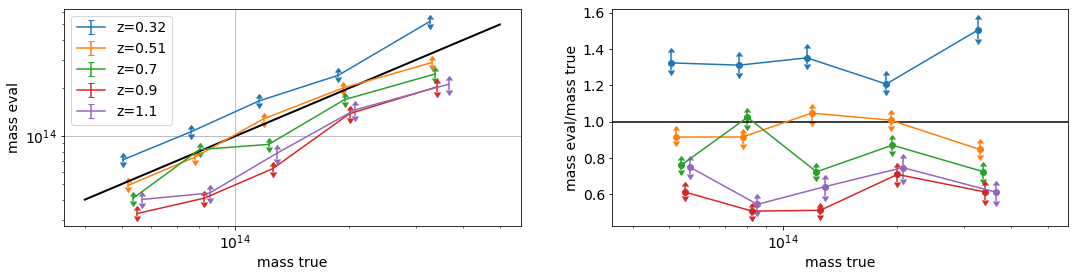

In [109]:

fig, ax = plt.subplots(1, 2, figsize=(18,4), sharex=True)

ax[0].errorbar(mass_cl[0,:]*0.94, mass_eval[0,:],\
             yerr = ((mass_eval - mass_min)[0,:], (mass_max - mass_eval)[0,:]),lolims=True, uplims=True, fmt='-', label ="z="+str(round(z_cl[0,0],2)))
ax[0].errorbar(mass_cl[1,:]*0.97, mass_eval[1,:],\
             yerr = ((mass_eval - mass_min)[1,:], (mass_max - mass_eval)[1,:]),lolims=True, uplims=True, fmt='-', label ="z="+str(round(z_cl[1,0],2)))
ax[0].errorbar(mass_cl[2,:]*1.00, mass_eval[2,:],\
             yerr = ((mass_eval - mass_min)[2,:], (mass_max-  mass_eval)[2,:]),lolims=True, uplims=True, fmt='-', label ="z="+str(round(z_cl[2,0],2)))
ax[0].errorbar(mass_cl[3,:]*1.03, mass_eval[3,:],\
             yerr = ((mass_eval - mass_min)[3,:], (mass_max - mass_eval)[3,:]),lolims=True, uplims=True, fmt='-', label ="z="+str(round(z_cl[3,0],2)))
ax[0].errorbar(mass_cl[4,:]*1.06, mass_eval[4,:],\
             yerr = ((mass_eval - mass_min)[4,:], (mass_max - mass_eval)[4,:]),lolims=True, uplims=True, fmt='-', label ="z="+str(round(z_cl[4,0],2)))

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].plot((4e13, 5e14),(4e13,5e14), color='black', lw=2)
ax[0].legend()
ax[0].set_xlabel("mass true")
ax[0].set_ylabel("mass eval")
ax[0].grid()

ax[1].errorbar(mass_cl[0,:]*0.94, mass_eval[0,:]/mass_cl[0,:],\
             yerr = ((mass_eval - mass_min)[0,:], (mass_max - mass_eval)[0,:])/mass_cl[0,:],lolims=True, uplims=True, fmt='-o', label ="z="+str(round(z_cl[0,0],2)))
ax[1].errorbar(mass_cl[1,:]*0.97, mass_eval[1,:]/mass_cl[1,:],\
             yerr = ((mass_eval - mass_min)[1,:], (mass_max - mass_eval)[1,:])/mass_cl[1,:],lolims=True, uplims=True, fmt='-o', label ="z="+str(round(z_cl[1,0],2)))
ax[1].errorbar(mass_cl[2,:]*1.00, mass_eval[2,:]/mass_cl[2,:],\
             yerr = ((mass_eval - mass_min)[2,:], (mass_max-  mass_eval)[2,:])/mass_cl[2,:],lolims=True, uplims=True, fmt='-o', label ="z="+str(round(z_cl[2,0],2)))
ax[1].errorbar(mass_cl[3,:]*1.03, mass_eval[3,:]/mass_cl[3,:],\
             yerr = ((mass_eval - mass_min)[3,:], (mass_max - mass_eval)[3,:])/mass_cl[3,:],lolims=True, uplims=True, fmt='-o', label ="z="+str(round(z_cl[3,0],2)))
ax[1].errorbar(mass_cl[4,:]*1.06, mass_eval[4,:]/mass_cl[4,:],\
             yerr = ((mass_eval - mass_min)[4,:], (mass_max - mass_eval)[4,:])/mass_cl[4,:],lolims=True, uplims=True, fmt='-o', label ="z="+str(round(z_cl[4,0],2)))

ax[1].set_xscale('log')
ax[1].axhline(1, color='black')
#ax[1].legend()
ax[1].set_xlabel("mass true")
ax[1].set_ylabel("mass eval/mass true")

#fig.savefig('figures/mass_evaluated_'+key+'.pdf',dpi=300)



In [110]:
np.save("output_data/magnification_range_fitted_mass_"+key+"_"+mdef+str(delta_so)+"_cM_"+Mc_relation,[mass_eval, mass_min, mass_max])

In [111]:
key

'LBGp'

In [112]:
np.save("output_data/magnification_fitted_mass_"+key+"_"+mdef+str(delta_so)+"_cM_"+Mc_relation,[mass_eval, mass_min, mass_max])

In [ ]:
fig, axes = plt.subplots(5,5, figsize=[20,15], sharex=True)
for i,h in zip([0,1,2,3,4],range(5)):
    for j,k in zip([0,1,2,3,4],range(5)):
        
        def func_Mpc_to_arcmin(x_Mpc):
            return Mpc_to_arcmin(x_Mpc, z=z_cl[i,j], cosmo=cosmo)
        
        def func_arcmin_to_Mpc(x_arc):
            return arcmin_to_Mpc(x_arc, z=z_cl[i,j], cosmo=cosmo)
        
        ax = axes[5-1-k,h]
        
        ax.errorbar(mu_profiles[i,2][0], mu_profiles[i,j][1] - corr[i,j] + 1,yerr=mu_profiles[i,j][2], fmt='')

        ax.axvline(1*healpy.nside2resol(4096, arcmin = True), linestyle="dashed")
    
        secax = ax.secondary_xaxis('top', functions=(func_arcmin_to_Mpc, func_Mpc_to_arcmin))
        secax.set_xlabel('$\\theta$ [Mpc]')

        r200 = scaled_radius(200, mass_cl[i,j], z_cl[i,j], cosmo)
        ax.axvline(func_Mpc_to_arcmin(r200))
        ax.axvline(func_Mpc_to_arcmin(0.25*r200))

        ax.text(0.55, 0.80, "<z>="+str(round(z_cl[i,j],2)), transform=ax.transAxes, fontsize='x-small')
        ax.text(0.55, 0.90, "<M/1e14>="+str(round(mass_cl[i,j]/1e14,2)), transform=ax.transAxes, fontsize='x-small');
        
        ax.axvspan(func_Mpc_to_arcmin(rmin_Mpc.value - 0.05), func_Mpc_to_arcmin(rmax_Mpc.value + 0.05), color='green', alpha=0.1, lw=0)
        
        ax.set_xlabel('$\\theta$ [arcmin]')
        ax.set_ylabel('$\mu$')
        ax.axhline(1)
        
        #ax.plot(mu_profiles[i,2][0], fmodel_guess[i, int(ind[i,j,k])](mu_profiles[i,2][0]),'r')
        ax.plot(mu_profiles[i,2][0], model[:,i,j],'k--')
        
plt.tight_layout()

plt.xlabel('$\\theta$ [arcmin]')
plt.ylabel('$\mu$')

axes[0,0].set_xscale('log')

for i in range(axes.shape[0]):
    axes[4,i].set_ylim(0.99,1.15)
    axes[3,i].set_ylim(0.99,1.15)
    axes[2,i].set_ylim(0.99,1.2)
    axes[1,i].set_ylim(0.99,1.3)
    axes[0,i].set_ylim(0.99,1.5)

NameError: name 'rsep' is not defined

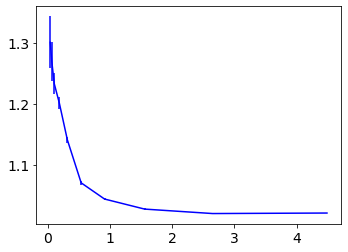

In [32]:
#i,j=2,0
#[plt.errorbar(arcmin_to_Mpc(mu_profiles[i,j][0],z_cl[i,j]), (mu_profiles[i,j][1]),yerr=mu_profiles[i,j][2], fmt='')  for j in range(5)]
#[plt.plot(rsep, model[:,i,j] + corr_mean -1,'--', lw=2) for j in range(5)]

plt.figure(figsize=(12,4))
plt.subplot(121)

i,j=0,2
plt.errorbar(arcmin_to_Mpc(mu_profiles[i,j][0],z_cl[i,j]), (mu_profiles[i,j][1]),yerr=mu_profiles[i,j][2], fmt='', c='b', ecolor='blue',  label="<z>="+str(round(z_cl[i,j],1))+" <M/1e14>="+str(round(mass_cl[i,j]/1e14,1)) ) 
plt.plot(rsep, model[:,i,j] + corr_mean -1,'b--', lw=2) 


i,j=3,2
plt.errorbar(arcmin_to_Mpc(mu_profiles[i,j][0],z_cl[i,j]), (mu_profiles[i,j][1]),yerr=mu_profiles[i,j][2], fmt='', c='r', ecolor='red', label="<z>="+str(round(z_cl[i,j],1))+" <M/1e14>="+str(round(mass_cl[i,j]/1e14,1)) )  
plt.plot(rsep, model[:,i,j] + corr_mean -1,'r--', lw=2, label='expected model') 

plt.xscale('log')
plt.xlabel('r [Mpc]')
plt.ylabel('$\mu$')
plt.legend()

#__________________
plt.subplot(122)

i,j=2,1
plt.errorbar(arcmin_to_Mpc(mu_profiles[i,j][0],z_cl[i,j]), (mu_profiles[i,j][1]),yerr=mu_profiles[i,j][2], fmt='', c='b', ecolor='blue',  label="<z>="+str(round(z_cl[i,j],1))+" <M/1e14>="+str(round(mass_cl[i,j]/1e14,1)) ) 
plt.plot(rsep, model[:,i,j] + corr_mean -1,'b--', lw=2) 


i,j=2,3
plt.errorbar(arcmin_to_Mpc(mu_profiles[i,j][0],z_cl[i,j]), (mu_profiles[i,j][1]),yerr=mu_profiles[i,j][2], fmt='', c='r', ecolor='red', label="<z>="+str(round(z_cl[i,j],1))+" <M/1e14>="+str(round(mass_cl[i,j]/1e14,1)) )  
plt.plot(rsep, model[:,i,j] + corr_mean -1,'r--', lw=2, label='expected model') 


plt.xscale('log')
plt.xlabel('r [Mpc]')
plt.ylabel('$\mu$')
plt.legend()

Text(0, 0.5, '$\\mu$')

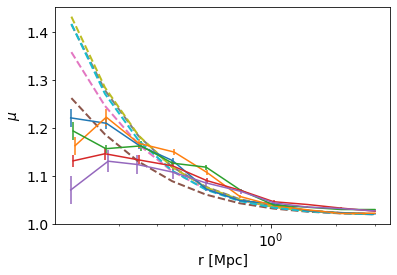

In [115]:
i,j=0,2
[plt.errorbar(arcmin_to_Mpc(mu_profiles[i,j][0],z_cl[i,j]), (mu_profiles[i,j][1]),yerr=mu_profiles[i,j][2], fmt='')  for i in range(5)]
[plt.plot(rsep, model[:,i,j] + corr_mean -1,'--', lw=2) for i in range(5)]

i,j=0,4
#plt.errorbar(mu_profiles[i,j][0], (mu_profiles[i,j][1]),yerr=mu_profiles[i,j][2], fmt='') 

i,j=4,0
#plt.errorbar(mu_profiles[i,j][0], (mu_profiles[i,j][1]),yerr=mu_profiles[i,j][2], fmt='') 

i,j=4,4
#plt.errorbar(mu_profiles[i,j][0], (mu_profiles[i,j][1]),yerr=mu_profiles[i,j][2], fmt='') 

plt.xscale('log')

plt.xlabel('r [Mpc]')
plt.ylabel('$\mu$')

In [116]:
#model with the full redshift distribution


rbins = clmm.polaraveraging.make_bins((rmin_Mpc).value, (rmax_Mpc).value, nbins=nbins, method='evenlog10width')

model = np.zeros((rbins.size-1, len(z_cl), len(mass_cl)))
for i in np.arange(z_cl.shape[0]):
    for j in np.arange(mass_cl.shape[1]):
        model[:,i,j] = magnification_model(rbins[:-1] + 0.5*(rbins[1:]-rbins[:-1]), mass_cl[i,j], z_cl[i,j],  zrand, cosmo, cosmo_ccl)

In [117]:
mean_corr = gal_cat['magnification'].mean()

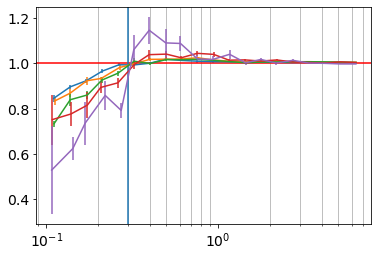

In [591]:
i,j = 4,0


[plt.errorbar(arcmin_to_Mpc(mu_profiles[i,j][0],z_cl[i,j]), (mu_profiles[i,j][1]-mean_corr +1)/model[:,i,j],yerr=mu_profiles[i,j][2], fmt='') for j in range(5)]

plt.axhline(1,color='red')
plt.xscale('log')
plt.grid(which="minor")

plt.axvline(0.3)

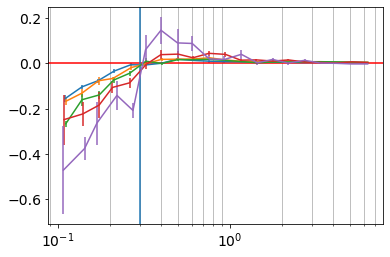

In [592]:
i,j = 4,0


[plt.errorbar(arcmin_to_Mpc(mu_profiles[i,j][0],z_cl[i,j]), ((mu_profiles[i,j][1]-mean_corr +1)-model[:,i,j])/model[:,i,j],yerr=mu_profiles[i,j][2], fmt='') for j in range(5)]

plt.axhline(0,color='red')
plt.xscale('log')
plt.grid(which="minor")

plt.axvline(0.3)

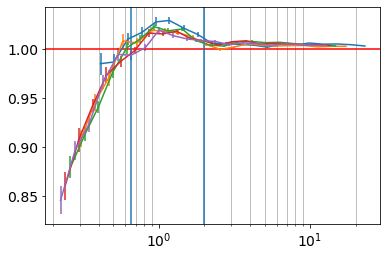

In [595]:
i,j = 0,0


[plt.errorbar(mu_profiles[i,j][0], (mu_profiles[i,j][1]-mean_corr +1)/model[:,i,j],yerr=mu_profiles[i,j][2], fmt='') for i in range(5)]

plt.axhline(1,color='red')
plt.xscale('log')
plt.grid(which="minor")

plt.axvline(0.65)
plt.axvline(2.)

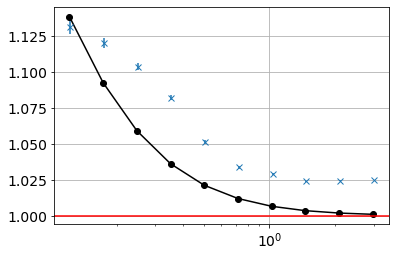

In [405]:
i,j = 0,0

plt.errorbar(arcmin_to_Mpc(mu_profiles[i,j][0],z_cl[i,j]), (mu_profiles[i,j][1]),yerr=mu_profiles[i,j][2], fmt='x')
plt.plot(rbins[:-1] + 0.5*(rbins[1:]-rbins[:-1]), model[:,i,j],'ko-')

plt.axhline(1,color='red')
plt.xscale('log')
plt.grid()

# Magnification biais reconstructed stacked profiles

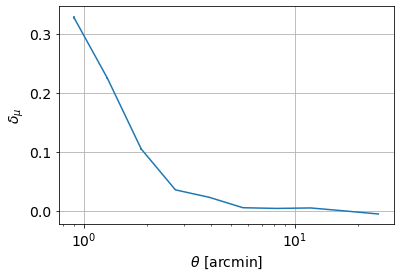

In [284]:
i,j = 0,0
plt.errorbar(mu_profiles[i,j][0], mu_bias(mu_profiles[i,j][1],alpha_cut) - mu_bias(gal_cat['magnification'][match[i,j][1]].mean(),alpha_cut),yerr=mu_profiles[i,j][2], fmt='')
plt.xscale('log')

plt.xlabel('$\\theta$ [arcmin]')
plt.ylabel('$\delta_\mu$')
plt.grid()

In [ ]:
mean_corr = mu_bias(gal_cat['magnification'].iloc[match[i,j][1]].mean(),alpha_cut)

fig, axes = plt.subplots(5,5, figsize=[20,15], sharex=True)
for i,h in zip([0,1,2,3,4],range(5)):
    for j,k in zip([0,1,2,3,4],range(5)):
        
        def func_Mpc_to_arcmin(x_Mpc):
            return Mpc_to_arcmin(x_Mpc, z=z_cl[i,j], cosmo=cosmo)
        
        def func_arcmin_to_Mpc(x_arc):
            return arcmin_to_Mpc(x_arc, z=z_cl[i,j], cosmo=cosmo)
        
        ax = axes[5-1-k,h]
        
        ax.errorbar(mu_profiles[i,j][0],  mu_bias(mu_profiles[i,j][1],alpha_cut) - mean_corr,yerr=mu_profiles[i,j][2], fmt='x-', ecolor='black')
        ax.errorbar(quant[i,j][0],quant[i,j][1],yerr=np.sqrt(np.diag(quant[i,j][2])),fmt='o', ecolor='red')
        
        #ax.axvline(1*healpy.nside2resol(4096, arcmin = True), linestyle="dashed")
    
        secax = ax.secondary_xaxis('top', functions=(func_arcmin_to_Mpc, func_Mpc_to_arcmin))
        secax.set_xlabel('$\\theta$ [Mpc]')

        #r200 = scaled_radius(200, mass_cl[i,j], z_cl[i,j], cosmo)
        #ax.axvline(func_Mpc_to_arcmin(r200))
        #ax.axvline(func_Mpc_to_arcmin(0.25*r200))

        ax.text(0.55, 0.80, "<z>="+str(round(z_cl[i,j],2)), transform=ax.transAxes, fontsize='x-small')
        ax.text(0.55, 0.90, "<M/1e14>="+str(round(mass_cl[i,j]/1e14,2)), transform=ax.transAxes, fontsize='x-small');
        
        ax.axvspan(func_Mpc_to_arcmin(0.2), func_Mpc_to_arcmin(3.5), color='green', alpha=0.1, lw=0)
        
        ax.set_xlabel('$\\theta$ [arcmin]')
        ax.set_ylabel('$\mu$')
        ax.axhline(0)
        
        
plt.tight_layout()

plt.xlabel('$\\theta$ [arcmin]')
plt.ylabel('$\mu$')

axes[0,0].set_xscale('log')
axes[0,0].set_xlim(0.4,30)

for i in range(axes.shape[0]):
    axes[4,i].set_ylim(0.99-1,1.25-1)
    axes[3,i].set_ylim(0.99-1,1.25-1)
    axes[2,i].set_ylim(0.99-1,1.3-1)
    axes[1,i].set_ylim(0.99-1,1.4-1)
    axes[0,i].set_ylim(0.99-1,1.6-1)